# Movies Analysis Clean Notebook

**Author:** Michael Pozo
***

# Data Setup

In [ ]:
# Import standard packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
%matplotlib inline

In [ ]:
# Establish connection to the IMDB datbase and pull the required data 

conn = sqlite3.connect('Phase 1 Project Data/im.db')
cursor_obj = conn.cursor()

movie_basics_df = pd.read_sql('''
    SELECT *
    FROM movie_basics
    ''', conn)

movie_ratings_df = pd.read_sql('''
    SELECT *
    FROM movie_ratings
    ''', conn)

director_df = pd.read_sql('''
    SELECT *
    FROM directors
    ''', conn)

persons_df = pd.read_sql('''
    SELECT *
    FROM persons
    ''', conn)


In [ ]:
#Merge dataframes together based on primary keys. Drop duplicates in resulting director dataframe.
#Final merge to create unified imdb dataframe

director_persons_df = pd.merge(director_df, persons_df, how = 'left', on = 'person_id')
director_persons_df.drop_duplicates(subset = 'movie_id', inplace = True)
movie_basics_ratings_df = pd.merge(movie_basics_df, movie_ratings_df, how ='left', on = 'movie_id')
imdb_df = pd.merge(director_persons_df, movie_basics_ratings_df, how = 'left', on = 'movie_id')
imdb_df.info()

In [ ]:
#Read 'The Numbers' data into budget_df
budget_df = pd.read_csv('Phase 1 Project Data/tn.movie_budgets.csv')
budget_df.info()

## Data Preparation


In [ ]:
# Clean the IMDB data to remove duplicate movies, null values, and columns that I will not be using. 
imdb_df.rename(columns = {'primary_name':'director_name'}, inplace = True)
imdb_df.drop(columns = ['birth_year', 'death_year', 'runtime_minutes'], axis = 1, inplace = True)
imdb_df.dropna(subset = ['director_name', 'primary_profession', 'original_title', 'genres'], axis = 0, inplace = True)
imdb_df.sort_values(by = ['primary_title', 'director_name', 'numvotes'], ascending = [True, True, False], inplace = True)
imdb_df.drop_duplicates(subset = ['primary_title', 'director_name'], keep = 'first', inplace = True)


In [ ]:
#Convert data types and create additional columns in the budgets dataframe
budget_df['production_budget'] = budget_df['production_budget'].str.replace(',','').str.replace('$','').astype(int)
budget_df['domestic_gross'] = budget_df['domestic_gross'].str.replace(',','').str.replace('$','').astype(int)
budget_df['worldwide_gross'] = budget_df['worldwide_gross'].str.replace(',','').str.replace('$','').astype(int)
budget_df['profit'] = budget_df['worldwide_gross'] - budget_df['production_budget']
budget_df['foreign_gross'] = budget_df['worldwide_gross'] - budget_df['domestic_gross']
budget_df['ROI'] = (budget_df['profit'] / budget_df['production_budget']) * 100
budget_df['release_date'] = pd.to_datetime(budget_df['release_date'])
budget_df['release_month'] = budget_df['release_date'].dt.month.astype(int)
budget_df['release_year'] = budget_df['release_date'].dt.year.astype(int)

In [ ]:
#Create the merged IMDB and Budget dataframe
merged_df = budget_df.merge(imdb_df, how = 'left', left_on = 'movie', right_on = 'primary_title')
imdb_budget_df = merged_df[merged_df['start_year'] == merged_df['release_year']]
imdb_budget_df.info()

## Data Modeling

***
Questions considered:
* When is the best time of year to release a movie (peak months)?
* During peak months, what genre of movie performs the best?
* Which directors in this genre are the most profitable and ROI positive?
* What is the relationship between production budget and profit for movies in this genre?

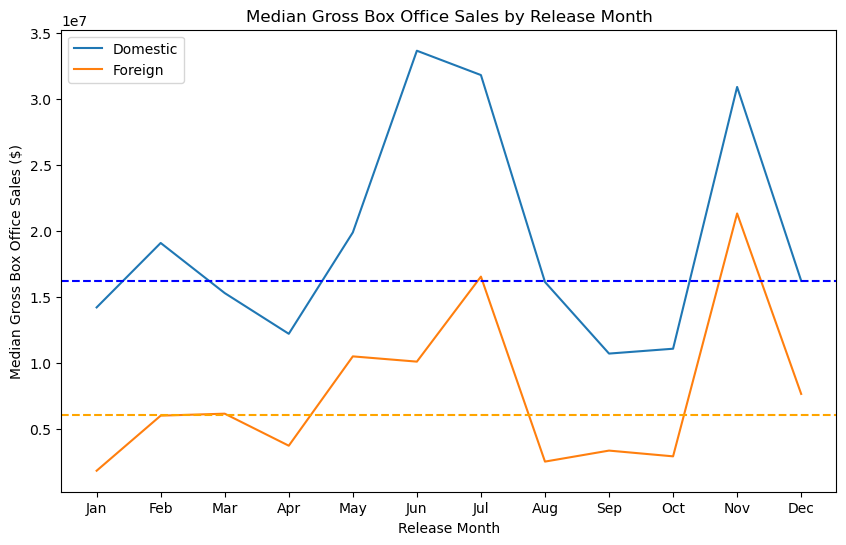

In [27]:
# Visualize monthly gross and domestic sales for all movies 
month_grouped_df = budget_df.groupby('release_month', axis = 0).median().sort_values('release_month', ascending = True)
domestic_median = month_grouped_df['domestic_gross'].median()
foreign_median = month_grouped_df['foreign_gross'].median()

plt.figure(figsize=(10,6))
sns.lineplot(x = month_grouped_df.index, y = 'domestic_gross', data = month_grouped_df, label = 'Domestic')
sns.lineplot(x = month_grouped_df.index, y = 'foreign_gross', data = month_grouped_df, label = 'Foreign')
plt.axhline(foreign_median, color = 'orange', linestyle = 'dashed')
plt.axhline(domestic_median, color = 'b', linestyle = 'dashed')
plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12], ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
plt.xlabel('Release Month')
plt.ylabel('Median Gross Box Office Sales ($)')
plt.title('Median Gross Box Office Sales by Release Month')
plt.legend(loc = 'upper left');

In [ ]:
#Calculate averge performance over the median for peak months

peak_domestic_performance_over_median = ((month_grouped_df['domestic_gross'].loc[[6,7,11]].mean() - domestic_median)/ domestic_median) * 100
print('Average domestic peak month performance over market median: ' + str(peak_domestic_performance_over_median))

peak_foreign_performance_over_median = ((month_grouped_df['foreign_gross'].loc[[6,7,11]].mean() - foreign_median)/ foreign_median) * 100
print('Average foreign month performance over the market median: ' + str(peak_foreign_performance_over_median))

June, July and November are the peak times for releasing a new movie into theaters. Gross domestic sales during these peak months are on average 98% better than the annual median. The same trend holds true for the foreign market with gross sales up 162% over the annual median during peak months. 

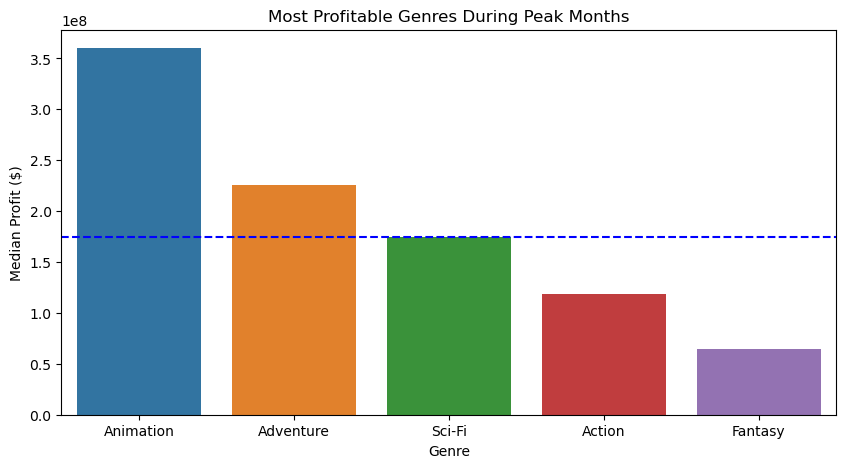

In [28]:
#Visualize which genres are the most profitable during peak months
imdb_budget_df['genres'] = imdb_budget_df['genres'].apply(lambda x: str(x).split(','))
imdb_budget_df = imdb_budget_df.explode('genres')
imdb_budget_df = imdb_budget_df[imdb_budget_df['worldwide_gross'] != 0]
filtered_df = imdb_budget_df.loc[imdb_budget_df['release_month'].isin([6,7,11])]
grouped_df = filtered_df.groupby(['genres']).median().sort_values(by=['profit'], ascending=[False]).reset_index()
top_5_genres_df = grouped_df.head(5)
median_profit = top_5_genres_df['profit'].median()
fig , ax = plt.subplots(figsize = (10,5))
sns.barplot(x = 'genres', y ='profit', data = top_5_genres_df);
ax.set_title('Most Profitable Genres During Peak Months')
ax.set_ylabel('Median Profit ($)')
ax.set_xlabel('Genre')
ax.axhline(median_profit, color = 'b', linestyle = 'dashed');

The animation genre is by far the most profitable during peak months. Microsoft should pursue making animated movies and look for top directors in the genre. 

In [ ]:
#Find the top 10 directors in the animation genre by proft
genres_subset = imdb_budget_df.loc[imdb_budget_df['genres'].isin(['Animation'])].reset_index()
genres_subset.drop_duplicates(subset = 'primary_title', inplace = True)
is_multi = genres_subset['director_name'].value_counts()>1
multi_director_list = genres_subset[genres_subset['director_name'].isin(is_multi[is_multi].index)]
profit_shortlist = multi_director_list.groupby('director_name').median().sort_values('profit', ascending = False).head(10)
profit_shortlist.reset_index()

In [ ]:
#Find the top 10 directors in the animation genre by ROI
roi_shortlist = multi_director_list.groupby('director_name').median().sort_values('ROI', ascending = False).head(10)
roi_shortlist.reset_index()

The list of top 10 directors in terms of profitability and ROI are the same! I will present this entire list to Microsoft as a shortlist of directors to pursue. 

In [ ]:
#Find relevant positive correlations within the animation genre 
genres_subset.corr()

Production budget is the most relevant field that is positively correlated with profit. Visualize the relationship.

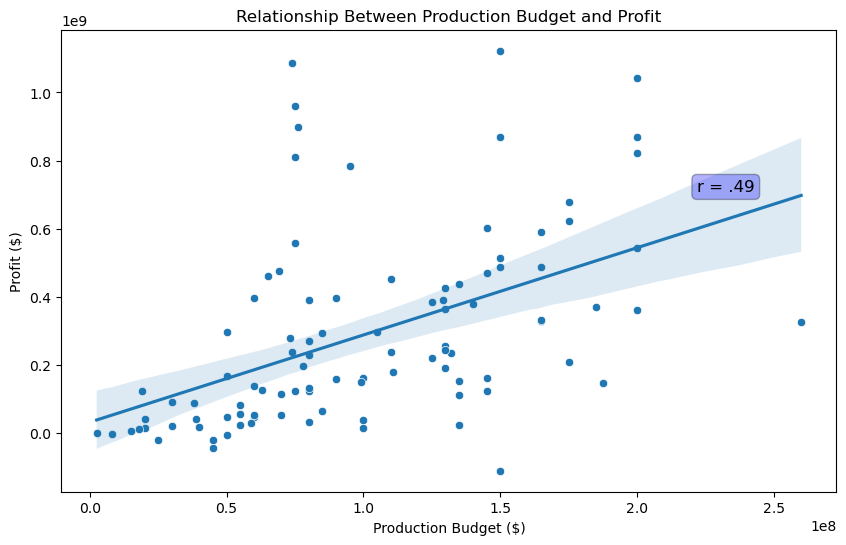

In [30]:
#Visualize the relationship between production budget and profit
fig , ax = plt.subplots(figsize = (10,6))
sns.scatterplot(x = 'production_budget', y = 'profit', data = genres_subset)
sns.regplot(data= genres_subset, x="production_budget", y='profit', scatter=False, ax=ax)
ax.set_title('Relationship Between Production Budget and Profit')
ax.set_ylabel('Profit ($)')
ax.set_xlabel('Production Budget ($)')
ax.annotate('r = .49', xy=(0.82, 0.65), xycoords='axes fraction', fontsize=12, bbox=dict(boxstyle='round', facecolor='b', alpha=0.3))
plt.show();


There is a moderately positive correlation between production budget and profit within the Animation genre. Profits generally improve as production budget increases. There is a large cluster of high profit movies within the middle 50% of the budget range, suggesting Microsoft may not need to spend beyond the average budget to achieve high profits.